# Temporal characterisation

## Deliverables:
    - Notebook : ok
        - Manual version
        - automatic : WiP
    - Documentation of the model : some comments in code
    - Test that everything works well : not done

## Goals:

Compare the environmental performance of 2 biobased insulation materials contrasted to a reference fossil insulation      material, applied     to buildings throught the prodution and end-of-life phases of the product.

## Scope:

The environmental performance is assessed through the climate change (CO2, Ch4, N2O), water use, and land use (area occupied) impacts


## LCIA method: 
The assessment is performed for 50 years of lifetime of the buildings
The EoL choices involve incineration, landfill, composting, and mulching (we are going to consider 2)

## Temporal scope:
    
## Tools
    Github
    Jupyter notebook
    Excel
    Brightway25
    Temporalis


How to consider the soil carbon sequestration/release/lost effect
For croplands is short, for forests is large


In [1]:
#from bw_temporalis.lcia import characterize_co2
import seaborn as sb
import bw2io as bi 
import bw2data as bd
import bw2calc as bc
import os               # to use "operating system dependent functionality"
import numpy as np      # "the fundamental package for scientific computing with Python"
import pandas as pd     # "high-performance, easy-to-use data structures and data analysis tools" for Python

from bw_temporalis import easy_timedelta_distribution, TemporalisLCA, TemporalDistribution
from bw_temporalis.lcia import characterize_co2

You should have created the correct project first. If not refer to the correct notebook to do so from scratch with a backuped project file.

In [2]:
bd.projects.set_current('My BW25workgroup')

In [3]:
bd.Database('temporalis-example').write({
    # CO2 emission
    ('temporalis-example', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "temporalis code": "co2",
    },
    # EPS Production Process
    ('temporalis-example', 'EPS_production'): {
        'exchanges': [
            {
                'amount': 24.3,
                'input': ('temporalis-example', 'CO2'),
                'type': 'biosphere',
                'temporal_distribution': TemporalDistribution(
                    np.array([1], dtype='timedelta64[Y]'),  # Yearly time steps
                    np.array([1])
                ),
            },
        ],
        'name': 'EPS production',
        'type': 'process'
    },
    # EPS End-of-Life Process (Incineration)
    ('temporalis-example', 'EPS_Incineration'): {
        'exchanges': [
            {
                'amount': 0.268,
                'input': ('temporalis-example', 'CO2'),
                'temporal_distribution': TemporalDistribution(
                    np.array([50], dtype='timedelta64[Y]'),  # Emission delayed 50 years
                    np.array([1])
                ),
                'type': 'biosphere'
            },
        ],
        'name': 'EPS Incineration',
        'type': 'process'
    },
    # Functional Unit I
    ('temporalis-example', 'Functional Unit - EPS'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('temporalis-example', 'EPS_production'),
                'type': 'technosphere'
            },
            {
                'amount': 1,
                'input': ('temporalis-example', 'EPS_Incineration'),
                'type': 'technosphere'
            },
        ],
        'name': 'Functional Unit - EPS',
        'type': 'process'
    },

    # Bio Sequestration Process
    ('temporalis-example', 'BIO_sequestration'): {
        'exchanges': [
            {
                'amount': -52.76,
                'input': ('temporalis-example', 'CO2'),
                'type': 'biosphere',
                'temporal_distribution': TemporalDistribution(
                    np.array([0], dtype='timedelta64[Y]'),  # Yearly time steps
                    np.array([1])
                ),
            },
        ],
        'name': 'BIO sequestration',
        'type': 'process'
    },
    
    # Bio Production Process
    ('temporalis-example', 'BIO_production'): {
        'exchanges': [
            {
                'amount': 0.927,
                'input': ('temporalis-example', 'CO2'),
                'type': 'biosphere',
                'temporal_distribution': TemporalDistribution(
                    np.array([1], dtype='timedelta64[Y]'),  # Yearly time steps
                    np.array([1])
                ),
            },
        ],
        'name': 'BIO production',
        'type': 'process'
    },
    # BIO End-of-Life Process (Incineration)
    ('temporalis-example', 'BIO_incineration'): {
        'exchanges': [
            {
                'amount': 54.6,
                'input': ('temporalis-example', 'CO2'),
                'temporal_distribution': TemporalDistribution(
                    np.array([50], dtype='timedelta64[Y]'),  # Emission delayed 50 years
                    np.array([1])
                ),
                'type': 'biosphere'
            },
        ],
        'name': 'BIO incineration',
        'type': 'process'
    },
    # Functional Unit II
    ('temporalis-example', 'Functional Unit - BIO'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('temporalis-example', 'BIO_sequestration'),
                'type': 'technosphere'
            },
            {
                'amount': 1,
                'input': ('temporalis-example', 'BIO_production'),
                'type': 'technosphere'
            },
            {
                'amount': 1,
                'input': ('temporalis-example', 'BIO_incineration'),
                'type': 'technosphere'
            },
        ],
        'name': 'Functional Unit - BIO',
        'type': 'process'
    },
    
})
    

11:16:45 [warning  ] Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████████████████████████████████████| 8/8 [00:00<00:00, 27369.03it/s]

11:16:45 [info     ] Vacuuming database            


In [4]:
bd.Method(("GWP", "example")).write([
    (('temporalis-example', "CO2"), 1)
])

In [5]:
def create_tlca_df(material):
    """
    Input  : material name : EPS / BIO at first
    Output : Dataframe containing the temporalis LCA
    """

    # --- LCA for the functional unit
    lca = bc.LCA({('temporalis-example', f'Functional Unit - {material}'): 1}, ("GWP", "example"))
    lca.lci()
    lca.lcia()

    # --- Temporalis computation
    tlca = TemporalisLCA(lca)
    tl   = tlca.build_timeline()
    df   = tl.build_dataframe()

    # -- Cumuative sum
    df[material] = df['amount'].cumsum()

    # -- Way to keep the activity names
    df = df.merge(
        bd.Database('temporalis-example').nodes_to_dataframe().rename(columns={'id': 'activity'}), 
        on='activity'
    )

    return df

Now we call the function for our funtional units : EPS / BIO.

In [61]:
df_eps = create_tlca_df('EPS')
df_bio = create_tlca_df('BIO')

Starting graph traversal
Calculation count: 2
Starting graph traversal
Calculation count: 3


In [58]:
df_eps

pandas.core.frame.DataFrame

Plot some informations

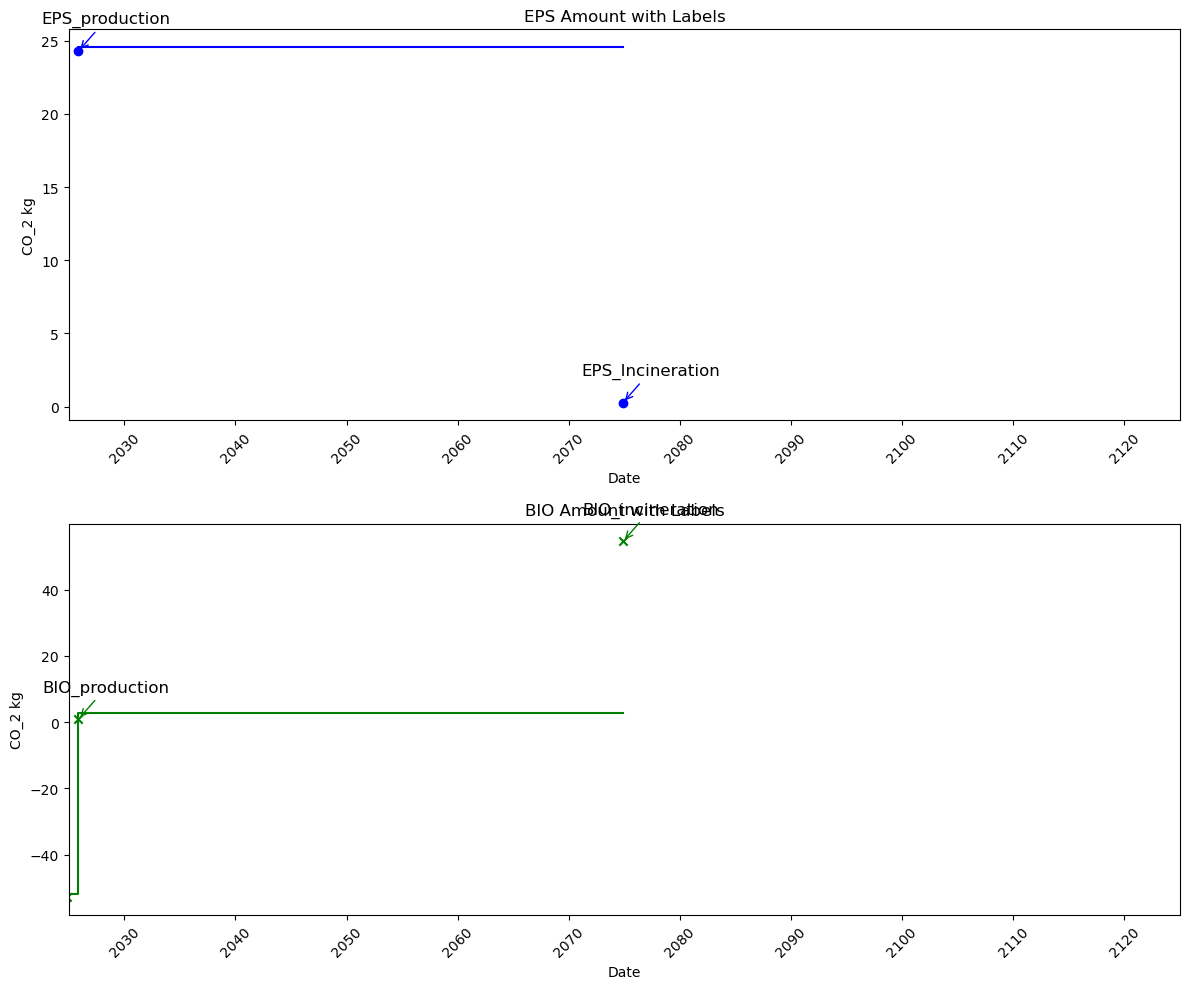

<Figure size 640x480 with 0 Axes>

In [72]:
import matplotlib.pyplot as plt
import datetime
# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# EPS Plot
ax1.scatter(df_eps['date'], df_eps['amount'], color='blue', marker='o', label='EPS Amount')
ax1.step(df_eps['date'], df_eps['EPS'], label='EPS Cumulative Amount', color='blue', linestyle='-')
ax1.set_title('EPS Amount with Labels')
ax1.set_xlabel('Date')
ax1.set_ylabel('CO_2 kg')
# ax1.legend()
ax1.tick_params(axis='x', rotation=45)
ax1.set_xlim([datetime.date(2025, 1, 1), datetime.date(2125, 1, 1)])
for i, row in df_eps.iterrows():
    ax1.annotate(
        row['code'],
        xy=(row['date'], row['amount']),
        xytext=(20, 20),  # Offset text position
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', color='blue'),
        fontsize=12,
        ha='center'
    )

# BIO Plot
ax2.scatter(df_bio['date'], df_bio['amount'], color='green', marker='x', label='BIO Amount')
ax2.step(df_bio['date'], df_bio['BIO'], label='BIO Cumulative Amount', color='green')
ax2.set_title('BIO Amount with Labels')
ax2.set_xlabel('Date')
ax2.set_ylabel('CO_2 kg')
# ax2.legend()
ax2.tick_params(axis='x', rotation=45)
ax2.set_xlim([datetime.date(2025, 1, 1), datetime.date(2125, 1, 1)])
# Add labels for each point in BIO
for i, row in df_bio.iterrows():
    ax2.annotate(
        row['code'],
        xy=(row['date'], row['amount']),
        xytext=(20, 20),  # Offset text position
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', color='green'),
        fontsize=12,
        ha='center'
    )
plt.tight_layout()
plt.show()
plt.savefig('EPS_BIO_amout.png')

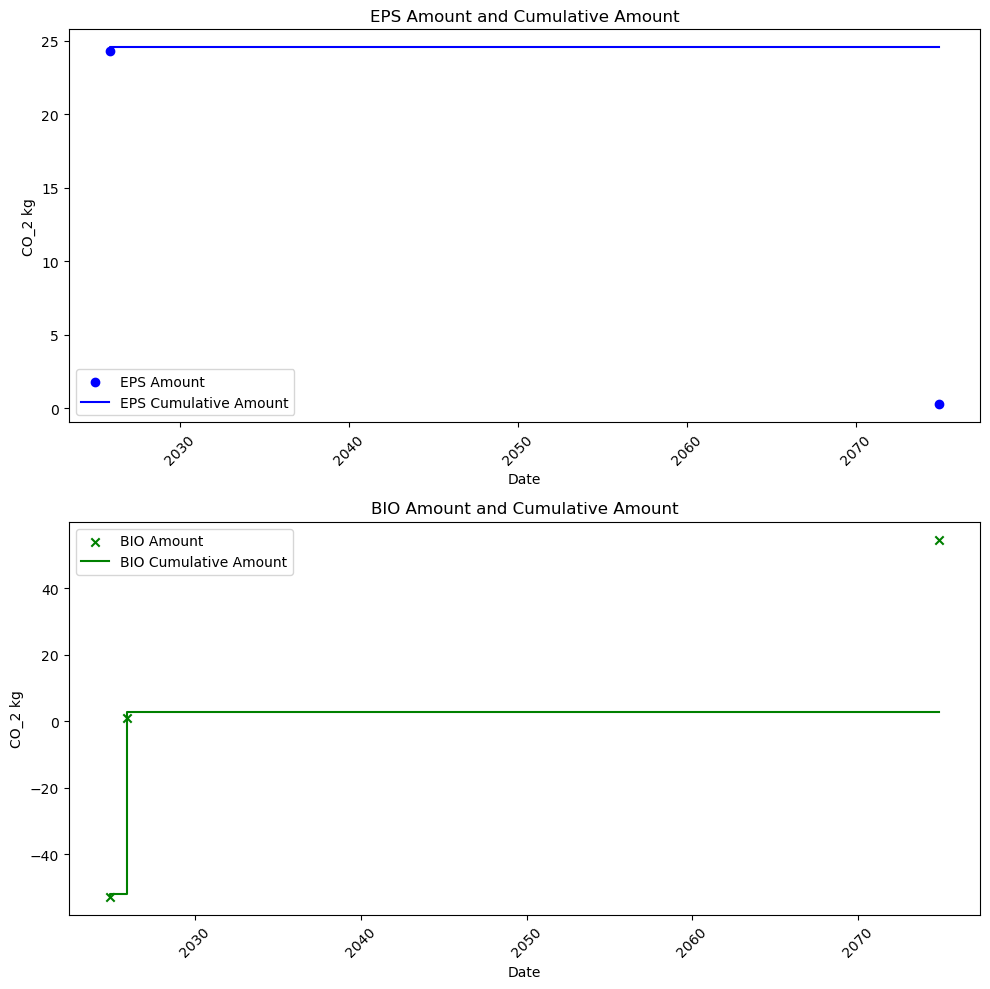

<Figure size 640x480 with 0 Axes>

In [73]:
# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))  # 2 rows, 1 column

# EPS Plot
ax1.scatter(df_eps['date'], df_eps['amount'], label='EPS Amount', color='blue', marker='o')
ax1.step(df_eps['date'], df_eps['EPS'], label='EPS Cumulative Amount', color='blue', linestyle='-')
ax1.set_title('EPS Amount and Cumulative Amount')
ax1.set_xlabel('Date')
ax1.set_ylabel('CO_2 kg')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# BIO Plot
ax2.scatter(df_bio['date'], df_bio['amount'], label='BIO Amount', color='green', marker='x')
ax2.step(df_bio['date'], df_bio['BIO'], label='BIO Cumulative Amount', color='green', linestyle='-')
ax2.set_title('BIO Amount and Cumulative Amount')
ax2.set_xlabel('Date')
ax2.set_ylabel('CO_2 kg')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
plt.savefig('EPS_BIO_cumulative.png')

We now would like to make a characterization.

In [74]:
for activity in bd.Database("temporalis-example"):
    if activity['name']=="carbon dioxide":
        carbdiox_id = activity.id

In [75]:
def create_characterized_df(material):
    """
    input  : material name
    output : Dataframe with charecterization 
    """

    # --- Initialize LCA for the specified functional unit and method
    lca = bc.LCA({('temporalis-example', f'Functional Unit - {material}'): 1}, ("GWP", "example"))
    lca.lci()
    lca.lcia()

    # --- Create a Temporalis LCA object and build the timeline
    tlca = TemporalisLCA(lca)
    tl = tlca.build_timeline()
    df = tl.build_dataframe()
    
    # --- Characterize the timeline's dataframe
    characterized_df = tl.characterize_dataframe(
        characterization_function=characterize_co2, 
        flow={bd.get_node(name="carbon dioxide", id=carbdiox_id).id},  # Flow ID for CO2
        cumsum=True  # Cumulative sum of amounts
    )

    # -- Filter out rows where the characterized amount is less than or equal to 0
    characterized_df = characterized_df[characterized_df['amount'] > 0]

    return characterized_df

In [76]:
characterized_dataframe_eps = create_characterized_df("EPS")

Starting graph traversal
Calculation count: 2


In [77]:
characterized_dataframe_bio = create_characterized_df('BIO')

Starting graph traversal
Calculation count: 3


In [78]:
characterized_dataframe_eps = characterized_dataframe_eps[characterized_dataframe_eps['amount'] > 0]

Text(0.5, 0, 'Time (years)')

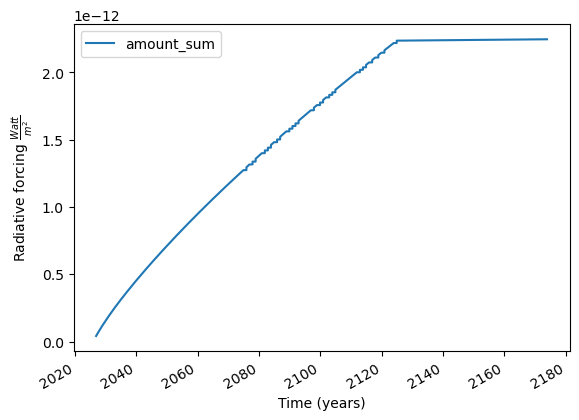

In [79]:
axes = characterized_dataframe_eps.plot(x="date", y="amount_sum")

axes.set_ylabel("Radiative forcing $\\frac{Watt}{m^{2}}$")
axes.set_xlabel("Time (years)")

Text(0.5, 0, 'Time (years)')

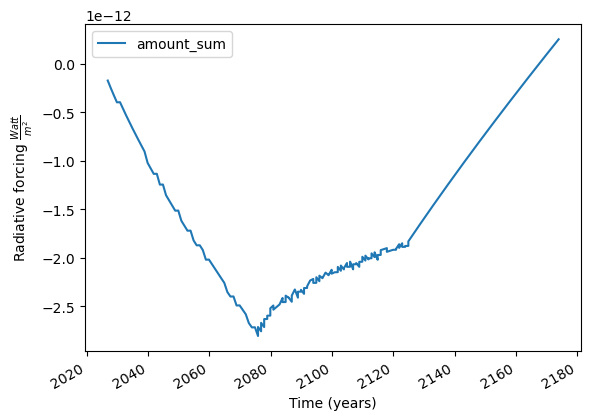

In [80]:
axes = characterized_dataframe_bio.plot(x="date", y="amount_sum")

axes.set_ylabel("Radiative forcing $\\frac{Watt}{m^{2}}$")
axes.set_xlabel("Time (years)")
